# Setup

## Version Test

Originally created with `R` version `4.1.0`

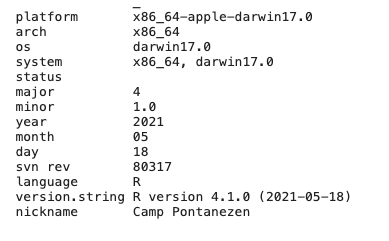

In [1]:
# Check version of R
version

               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          2.0                         
year           2022                        
month          04                          
day            22                          
svn rev        82229                       
language       R                           
version.string R version 4.2.0 (2022-04-22)
nickname       Vigorous Calisthenics       

## Load Libraries

In [1]:
library(tidyverse)
library(data.table)
library(broom)
library(dtplyr)
library(lme4) #for lmer & glmer models
library(lmerTest)
library(ggbeeswarm)
library(cowplot)
library(leaflet) # for maps
library(psych)
library(corrplot)
library(sjPlot) #for plotting lmer and glmer mods

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching pac

# Import Data

## Run 1 Onboarding/Offboarding

Run 1 | Sept - Dec 2022

In [7]:
dataFileNumeric = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_qualtrics_onboardingOffboarding.csv'
run1_q <- as.data.table(read_csv(dataFileNumeric, show_col_types = FALSE))
run1_q = run1_q[Status=='0'] # select non-preview, non-metadata rows

## Rename Domains

### Description

When doing the second and third versions of SONA testing some domains were being incorrectly labeled by number.

For example starting at 4:
```
'ib_domains_success_4'
'ib_domains_success_5'
'ib_domains_success_6'
'ib_domains_success_7'
```
And then jumpping around from 27 -> 29 -> 37 -> 31, etc.
```
'ib_domains_success_23'
'ib_domains_success_24'
'ib_domains_success_36'
'ib_domains_success_25'
'ib_domains_success_26'
'ib_domains_success_27'
'ib_domains_success_29'
'ib_domains_success_37'
'ib_domains_success_31'
'ib_domains_success_32'
'ib_domains_success_33'
'ib_domains_success_34'
'ib_domains_success_35'
```
Since we are using a pass through logic on Qualtrics the ORDER of all the domains should remain the same for each category.

This means that we can strip away the trailing number and replace it with a more meaningful domain description and that this should sync up for all version of data (sona I-III and retest) and categories...

**NOTE:** There are some renamed and new domain categories in the retest data. This is not that important...more for refining the measure going forward.

### Rename Function

In [8]:
# number of domains
domain_num = run1_q %>% select(contains('ib_domain_goal')) %>% as_tibble() %>% ncol()

In [9]:
rename_domains = function(df, domain_num){
    # list of domain categories
    ib_domain_cats = c('ambition', 'effort', 'external',
                       'goal', 'import', 'internal',
                       'rank', 'satis', 'source', 'specific',
                       'success', 'time'
                      )

    domain_names = c("Diet",
                     "Exercise",
                     "MentalPersonal_Health",
                     "Medical_Health",
                     "Sleep",
                     "Alcohol_drug",
                     "Online",
                     "Phone",
                     "Video games",
                     "Reading_leisure",
                     "SocialMedia",
                     "Sports_playing",
                     "TV_Streaming",
                     "Family",
                     "Friends",
                     "Partner",
                     "Social_life",
                     "Hobby",
                     "Housework",
                     "Cooking",
                     "Work_School",
                     "Environment",
                     "Culture",
                     "Learning",
                     "Self-Improvement",
                     "Volunteering",
                     "Community involvement",
                     "Admin",
                     "Future_Planning",
                     "Finances",
                     "Time_Management",
                     "Punctuality",
                     "Personal_Values",
                     "Other"
                    )

    for (i in 1:length(ib_domain_cats)) {
        # make a list of the existing names for each cateogry
        old_names = df %>%
            select(starts_with('ib_domain')) %>%
            select(contains(ib_domain_cats[i], ignore.case = FALSE)) %>%
            as_tibble() %>%
            names()

        # make a list of names with category and domain
        new_names = rep('ib_domain_', domain_num)
        new_names = paste0(new_names,ib_domain_cats[i], '_', domain_names)

        # replace existing names with new names
        df = df %>%
            rename_at(vars(all_of(old_names)), ~ new_names) %>%
            as_tibble()
    }

    return(df)
}

### Rename Domains for each DF

In [10]:
run1_q = rename_domains(run1_q, domain_num)

### Add Survey Version

In [11]:
run1_onB = run1_q %>%
    filter(EndDate < '2022-12-12 00:00:00')

run1_offB = run1_q %>%
    filter(EndDate >= '2022-12-12 00:00:00')

In [12]:
run1_onB$version = 'onB'
run1_offB$version = 'offB'

### Match run 1 subjects

In [13]:
run1_subs_full = read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_subjects.csv', show_col_types = FALSE)
run1_subs = run1_subs_full$`Student Number`

In [14]:
run1_onB$studentNumber = as.numeric(run1_onB$consent_sonaID)
run1_offB$studentNumber = as.numeric(run1_offB$consent_sonaID)

In [15]:
run1_onB = run1_onB %>%
    subset(studentNumber %in% run1_subs) %>%
    subset(Finished == 1)

run1_offB = run1_offB %>%
    subset(studentNumber %in% run1_subs) %>%
    subset(Finished == 1)

### Remove duplicates

In [16]:
# take the first instance when duplicates
run1_onB = run1_onB %>%
   arrange(EndDate) %>% # use desc(EndDate) to take last instance
   group_by(studentNumber) %>%
    slice(1)

In [17]:
run1_offB = run1_offB %>%
   arrange(EndDate) %>% # use desc(EndDate) to take last instance
   group_by(studentNumber) %>%
    slice(1)

In [18]:
print(dim(run1_onB))
print(dim(run1_offB))

[1]   67 1844
[1]   47 1844


In [19]:
length(unique(run1_onB$studentNumber))

[1] 67

In [20]:
length(unique(run1_offB$studentNumber))

[1] 47

### Join

In [21]:
q_df = rbindlist(list(run1_offB, run1_onB), fill = TRUE)

# Timing

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,95,66.55561,40.77626,54.8,61.64784,32.09829,17.43333,194.5667,177.1333,1.112906,0.5428518,4.183556


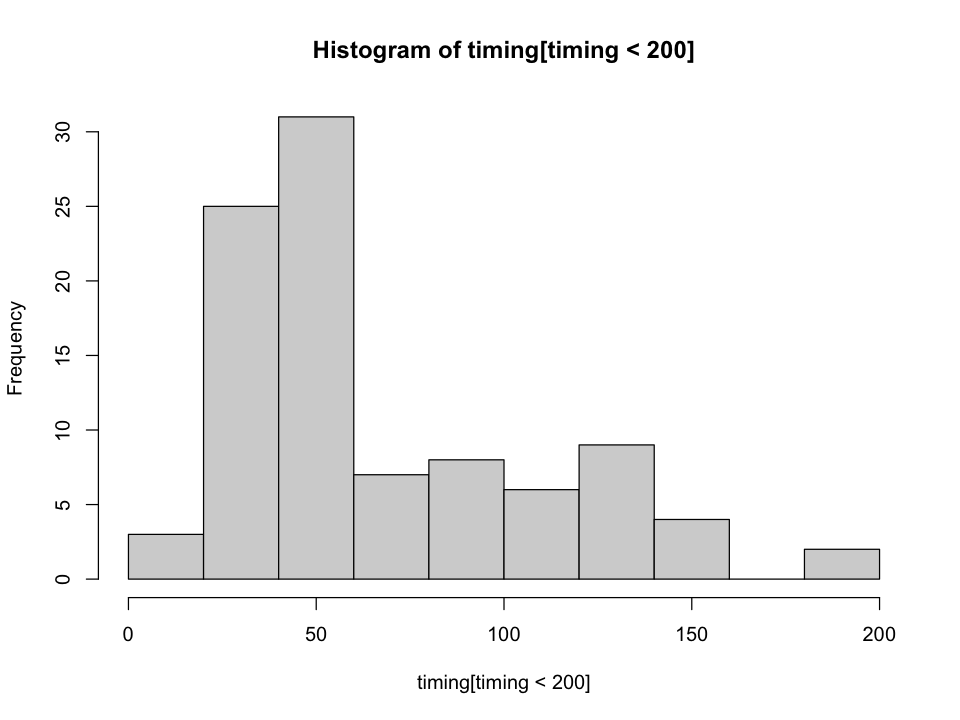

In [22]:
options(repr.plot.width = 8, repr.plot.height = 6)

timing = as.numeric(q_df$`Duration (in seconds)`)/60
hist(timing[timing<200])
describe(timing[timing<200])

In [23]:
sum(timing>200)

[1] 19

Note that there were 35 peoople who took over 3 hours 20 min...should they be removed??

# Demographics

Select all columns that contain demographic information.

This is pulled from the two demographic blocks in the questionnaire: 
1. `demographic-standard`
2. `demographic-vib`

## Convert height

In [24]:
# Calculate height in CM
q_df$height = as.numeric(q_df$`height#1_1`) * 30.48 + as.numeric(q_df$`height#2_1`) * 2.54

# note that there are some NAs as I had not set up the validation correctly. Should be fixed now...

## Add BMI

In [25]:
# add bmi
q_df$bmi = (as.numeric(q_df$weight)/2.2) / (q_df$height/100)^2

## Rate accomplishments

Need to rate accomplishments...

In [30]:
# loading google sheet where coding of accomplishments (1-7) is done
library(googlesheets4)

accomps = read_sheet("https://docs.google.com/spreadsheets/d/1NvRw00M79UANZkY0hGJ6A_E8IWg-pviysdbLOONZkYM/edit?usp=sharing")

ERROR: [1m[33mError[39m in [1m[1m[30m[47m`cli::cli_abort()`[49m[39m:[22m
[33m![39m [1m[22mCan't get Google credentials.
[36mℹ[39m Are you running [34mgooglesheets4[39m in a non-interactive session? Consider:
• Call [30m[47m`gs4_deauth()`[49m[39m to prevent the attempt to get credentials.
• Call [30m[47m`gs4_auth()`[49m[39m directly with all necessary specifics.
[36mℹ[39m See gargle's "Non-interactive auth" vignette for more details:
[36mℹ[39m [3m[34m<https://gargle.r-lib.org/articles/non-interactive-auth.html>[39m[23m


In [42]:
# need to finish rating accomplishments
q_df$accomp_score = NA

In [43]:
demographics = q_df[, list(subjectID, StartDate, LocationLatitude, LocationLongitude,
                         gender, age, education, ethnicity, father_education, mother_education,
                         marital_status, employment_status, children_1, income, parents_income,
                         net_worth, parents_net_worth, housing_status,
                                macarthur_sss, macarthur_sss_parent, 
                                job, accomp_personal, accomp_career, accomp_score,
                                weight, height, bmi,
                                sat_score, gre_score_verbal, gre_score_quant, gpa_highschool, gpa_undergrad
                               )] # have added some more to this, and need to add race

# Intention-Behavior

All measures that relate to the intention-behavior gap will be collected in a single `dataframe`.

To start we will just initialize a `dataframe` with `subjectID`

In [26]:
idx = which(names(q_df)=='studentNumber')
ib_measures_df = as.data.frame(q_df)[idx]

In [27]:
head(ib_measures_df, 3)

,studentNumber
,<dbl>
1,1004444942
2,1004637244
3,1005242088


### Overall Gap | Pre/Post

Before beginning the measure we had subjects provide an initial estimate of their **Intention Behavior Gap**.

We asked:

>When you consider the intentions or goals that you have for yourself, to what degree do you feel like you are successful in actually accomplishing those goals?

>Please consider both big and small intentions or goals.

We asked them to respond on a scale of `0` to `100`, where `100` would indicate that they had *NO GAP*

Therefore the gap is calculated by:
$$IBGap{_{pre}} = 100 - Score$$

In [28]:
# calculate
overall_gap_pre = 100-as.numeric(q_df$overall_success_pre_1)
# add to measure df
ib_measures_df$overall_gap_pre = overall_gap_pre

At the end of the measure we then asked the same question, requesting that they provide a single overall **Intention Behavior Gap** score.

We asked:

> Overall, When you consider all of the intentions and goals that you have for yourself, to what
degree do you feel like you are successful in actually accomplishing these goals and intentions?

> Please consider both big and small intentions or goals.

Again we asked them to respond on a scale of `0` to `100`, where `100` would indicate that they had *NO GAP*

Therefore the gap is calculated by:
$$IBGap{_{post}} = 100 - Score$$

In [29]:
# calculate
overall_gap_post = 100-as.numeric(q_df$overall_success_post_1)
# add to measure df
ib_measures_df$overall_gap_post = overall_gap_post

### Global Gap

`THIS IS NOT USED IN THE CURRENT VERSION OF THE MEASURE`

The global action measure was an attempt to have people consider all the different **goals** and **intentions** they might set out for themselves across different timeframes:
- day
- week
- month
- year

We then asked them to estimate both their:
1. Beginning of day **belief** about what percentage of their intentions they would accomplish
2. End of day actual **achievement** of their goals and intentions

For example, for `day` the questions were:

**Achievement**
```
Please estimate to what extent, on AVERAGE, you achieve your goals, intentions, tasks and responsibilities on a DAILY basis.

For example, at the END OF THE DAY when you think about all of the things you hoped to do that day, what percentage do you usually accomplish?
```

**Belief**
```
A similar question but...

Now we would like to know at the BEGINNING OF EACH DAY, what percentage of your DAILY goals, tasks and responsibilities do you BELIEVE you will accomplish?

In other words, sometimes we set goals for ourselves without really believing we’ll get to them, but at least hoping we will. We want you to estimate what percentage of your goals you really, honestly believe you will accomplish each day.
```

We asked the same two questions for each timeframe listed above.

In [30]:
# create df with all vars
global_vars = as.data.frame(q_df) %>% 
  select(subjectID,
         global_day_actual_1, global_day_belief_1,
         global_week_actual_1, global_week_belief_1,
         global_month_actual_1, global_month_belief_1,
         global_year_actual_1, global_year_belief_1,
         global_overall_1
        )

# get average achievement gap
global_achieve = global_vars %>%
  select(contains('actual')) %>%
  lapply(as.numeric) %>%
  data.frame() %>%
  rowMeans(na.rm = TRUE)

# flip to get the gap instead of the achievement
global_achieve_gap = 100-global_achieve
# add to measure df
ib_measures_df$global_achieve_gap = global_achieve_gap

# get average belief gap
global_belief = global_vars %>%
  select(contains('belief')) %>%
  lapply(as.numeric) %>%
  data.frame() %>%
  rowMeans(na.rm = TRUE)

# flip to get the gap instead of the achievement
global_belief_gap = 100-global_belief
# add to measure df
ib_measures_df$global_belief_gap = global_belief_gap

# calculate difference between achieve and belief
ib_measures_df$belief_achieve_gap = global_belief - global_achieve

ERROR: [1m[33mError[39m in [1m[1m`select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `subjectID` doesn't exist.


**Note to self**:

Not sure how to think of `belief_achieve_gap` as a metric?

Perhaps should be correlated with **optimism** and or **ambition**?

### Categorical Gap

`THIS IS NOT USED IN NEWER VERSION OF THE MEASURE`

This version of the measure asked people to estimate the time they spent **on average per weekday** for a number of time use categories.

Subjects filled out how many hours they **actually** spent on each of these categories and also how much time they **intended** to spend on each category.

To calculate the gap we calculate as follows:

$$Gap = \frac{\sum_{i=1}^{i=k} intendCategory_{i} - 24}{24}$$

where `k` is the number of categories of activities, and `intendCategory` is the duration of the activity

**Note to self:** Could be interesting to see what categories have the biggest/smallest gaps and in which direction...

In [115]:
# select columns related to action categorical measurement
cat_intend = as.data.frame(q_df) %>%
  select(contains('cat_intend')) %>%
  lapply(as.numeric) %>%
  data.frame() %>%
  rowSums(na.rm = TRUE)

cat_intend_gap = ((cat_intend - 24)/24) * 100

# add to measure df
ib_measures_df$cat_intend_gap = cat_intend_gap

### Domains

The domain questions is similar to the `categorical gap` measure in that it asks about specific categories of activity but it differs in a few ways:

1. Many more (34) categories (i.e. greater specificity)
2. Opportunity to indicate that you do not have a goal in a category. e.g. perhaps you sleep a certain number of hours each night but you really do not have any sort of sleep goal. If you don't have a goal then we do not count it
3. Opportunity to indicate how important your goal is in each category. This can be used to "weight" the intention behavior gap if we like.
4. Indicate additional attributes of your goals in each category including:
    - `specificity`
    - `satisfaction`
    - `goal setting style`
    - `internal motivation`
    - `external motivation`
    - `gap cause`
    - `gap rank`
    
**Note to self:** Many other things to look at here, for example:
- what is the average gap if grouped by how important the goal is?
- what is the average gap if grouped by external motivation vs. internal motivation?
- etc...

#### Rescale Domain Importance

**NOTE** We are NOT doing this for now.

The weighted domain gap did not perform better than the standard gap in terms of correlating with validation measures.

This is something that needs to be revisited.

In [138]:
# # Importance scaling function
# fun_import = function(x) {
#     (((x - 1) * (1.5 - 0.5)) / (7 - 1)) + 0.5
# } 

In [139]:
# # rescale all importance columns
# scaled_domains[,grepl('import', colnames(scaled_domains))] = apply(scaled_domains[,grepl('import', colnames(scaled_domains))], 2, fun_import)


### Domains | Unweighted

In [126]:
ib_domain_ix = which(grepl('ib_domain', colnames(q_df)) 
                     & !grepl('domain_rank', colnames(q_df)) 
                     & !grepl('domain_goal', colnames(q_df))
                     & !grepl('domain_amount', colnames(q_df))
                    )

In [127]:
# make numeric
domains = as_tibble(q_df)[, ib_domain_ix] %>%
    lapply(as.numeric) %>%
    as_tibble()

In [128]:
# select columns related to action categorical measurement
domain_success = domains %>%
  select(contains('ib_domain_success')) %>%
  data.frame() %>%
  rowMeans(na.rm = TRUE)

# gap is opposite of success
# but not exactly opposite as we are converting to a scale that includes 0 to allow for NO gap...
domain_gap = 100 - domain_success 

# add to measure df
ib_measures_df$domain_gap = domain_gap
ib_measures_df$version = q_df$version

#### Create DF IB Gap for all domains


In [140]:
domains$studentNumber = q_df$studentNumber
domains$version = q_df$version

In [141]:
ib_gap_domains = domains %>%
  select(contains('ib_domain_success'), 'studentNumber', 'version')

In [144]:
# convert "success" to gap
studentNumber = ib_gap_domains$studentNumber
ib_gap_domains = cbind(100 - select(ib_gap_domains, -c(studentNumber, version)), studentNumber)

In [147]:
ib_gap_domains$version = q_df$version

In [148]:
# rename domains (since it is now gap, and not success)
 domain_names = c("Diet",
                     "Exercise",
                     "MentalPersonal_Health",
                     "Medical_Health",
                     "Sleep",
                     "Alcohol_drug",
                     "Online",
                     "Phone",
                     "Video games",
                     "Reading_leisure",
                     "SocialMedia",
                     "Sports_playing",
                     "TV_Streaming",
                     "Family",
                     "Friends",
                     "Partner",
                     "Social_life",
                     "Hobby",
                     "Housework",
                     "Cooking",
                     "Work_School",
                     "Environment",
                     "Culture",
                     "Learning",
                     "Self-Improvement",
                     "Volunteering",
                     "Community involvement",
                     "Admin",
                     "Future_Planning",
                     "Finances",
                     "Time_Management",
                     "Punctuality",
                     "Personal_Values",
                     "Other"
                    )

new_names = paste0('ib_domain_gap_', c(domain_names, 'studentNumber', 'version'))
ib_gap_domains = setNames(ib_gap_domains, new_names)

In [149]:
head(ib_gap_domains, 3)

,ib_domain_gap_Diet,ib_domain_gap_Exercise,ib_domain_gap_MentalPersonal_Health,ib_domain_gap_Medical_Health,ib_domain_gap_Sleep,ib_domain_gap_Alcohol_drug,ib_domain_gap_Online,ib_domain_gap_Phone,ib_domain_gap_Video games,ib_domain_gap_Reading_leisure,⋯,ib_domain_gap_Community involvement,ib_domain_gap_Admin,ib_domain_gap_Future_Planning,ib_domain_gap_Finances,ib_domain_gap_Time_Management,ib_domain_gap_Punctuality,ib_domain_gap_Personal_Values,ib_domain_gap_Other,ib_domain_gap_studentNumber,ib_domain_gap_version
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,NA,29,NA,NA,NA,NA,NA,71,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,1004444942,offB
2,31,89,63,NA,18,NA,NA,67,5,88,⋯,70,NA,67,46,63,84,76,16,1004637244,offB
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,34,NA,NA,NA,NA,NA,1005242088,offB


In [157]:
head(ib_measures_df, 3)


,studentNumber,overall_gap_pre,overall_gap_post,domain_gap,version
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1004444942,29,37,36.80000,offB
2,1004637244,30,23,52.47826,offB
3,1005242088,14,14,18.00000,offB


### Domains | Weighted

Assuming that people don't care about all domains equally, we think that the gap should reflect this.

In other words if you only care a bit about sleep and a lot about diet then a gap of 10% matters **more** in terms of diet.

**Note to self**: There is probably some point of indifference where improving diet and improving sleep converge...

---

The methods we are using is to use the following formula:

$$Gap = \frac{\sum_{i=1}^{i=k} ibDomainGap_{i} * ibDomainImportance_{i}}{k}$$

where `k` is the number of categories of domains, `ibDomainGap` is the goal domain, and `ibDomainImportance` is how important that domain is to the subject.

Note that `ibDomainImportance` was originally on a 7 point Likert scale but has been re-scaled to a 0.5 - 1.5 scale so that the gap is downweighted for domains that are less important and upweighted for domains that are more important.

In [141]:
domain_success = scaled_domains %>%
    select(contains('ib_domains_success'))%>%
    data.frame()

In [142]:
head(describe(domain_success), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ib_domains_success_1,1,204,3.777059,1.733503,4.00,3.783415,2.223900,0.94,7,6.06,-0.12867921,-1.0431543,0.1213695
ib_domains_success_2,2,244,3.604426,1.877440,3.97,3.553776,2.312856,0.94,7,6.06,0.10067246,-1.2424231,0.1201908
ib_domains_success_3,3,221,3.817828,1.636049,3.94,3.807458,2.134944,0.94,7,6.06,0.08156233,-0.8515728,0.1100526


In [143]:
# convert success to gap...
# using 7 instead of 8 to flip values but include 0
gap = 7-domain_success

In [144]:
importance = scaled_domains %>%
    select(contains('ib_domains_import')) %>%
    data.frame()

In [145]:
head(gap,2)

,ib_domains_success_1,ib_domains_success_2,ib_domains_success_3,ib_domains_success_4,ib_domains_success_5,ib_domains_success_6,ib_domains_success_7,ib_domains_success_8,ib_domains_success_9,ib_domains_success_10,⋯,ib_domains_success_23,ib_domains_success_24,ib_domains_success_25,ib_domains_success_26,ib_domains_success_27,ib_domains_success_28,ib_domains_success_29,ib_domains_success_30,ib_domains_success_31,ib_domains_success_32
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.5,1.5,1.5,1.5,1.5,3,NA,NA,NA,NA,⋯,1.5,NA,3,1.5,0,0,0,0,0,0
2,NA,3.0,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0


In [146]:
head(importance, 2)

,ib_domains_import_1,ib_domains_import_2,ib_domains_import_3,ib_domains_import_4,ib_domains_import_5,ib_domains_import_6,ib_domains_import_7,ib_domains_import_8,ib_domains_import_9,ib_domains_import_10,⋯,ib_domains_import_23,ib_domains_import_24,ib_domains_import_25,ib_domains_import_26,ib_domains_import_27,ib_domains_import_28,ib_domains_import_29,ib_domains_import_30,ib_domains_import_31,ib_domains_import_32
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.25,1.00,1,1.25,1,0.5,NA,NA,NA,NA,⋯,1.5,NA,1.25,1.5,1.25,1.5,1.25,1.25,1.5,1.5
2,NA,1.25,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.5


In [147]:
w_domain_gap = gap * importance
head(w_domain_gap, 3)

,ib_domains_success_1,ib_domains_success_2,ib_domains_success_3,ib_domains_success_4,ib_domains_success_5,ib_domains_success_6,ib_domains_success_7,ib_domains_success_8,ib_domains_success_9,ib_domains_success_10,⋯,ib_domains_success_23,ib_domains_success_24,ib_domains_success_25,ib_domains_success_26,ib_domains_success_27,ib_domains_success_28,ib_domains_success_29,ib_domains_success_30,ib_domains_success_31,ib_domains_success_32
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.875,1.50,1.50,1.875,1.50,1.5,NA,NA,NA,NA,⋯,2.25,NA,3.75,2.25,0.000,0,0.00,0.0,0,0.000
2,NA,3.75,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.000
3,2.250,4.50,2.25,NA,2.25,0.0,NA,4.5,4.5,5.625,⋯,NA,3.75,3.75,3.75,1.875,NA,2.25,4.5,0,1.875


In [148]:
# avg across rows
w_domain_gap = w_domain_gap %>%
    rowMeans(na.rm = TRUE)

# add to measure df
ib_measures_df$w_domain_gap = w_domain_gap


### Eisenhower Matrix

We asked subjects to estimate the amount of time they spend in each of the four quadrants defiend by the [Eisenhower Matrix](https://jamesclear.com/eisenhower-box).

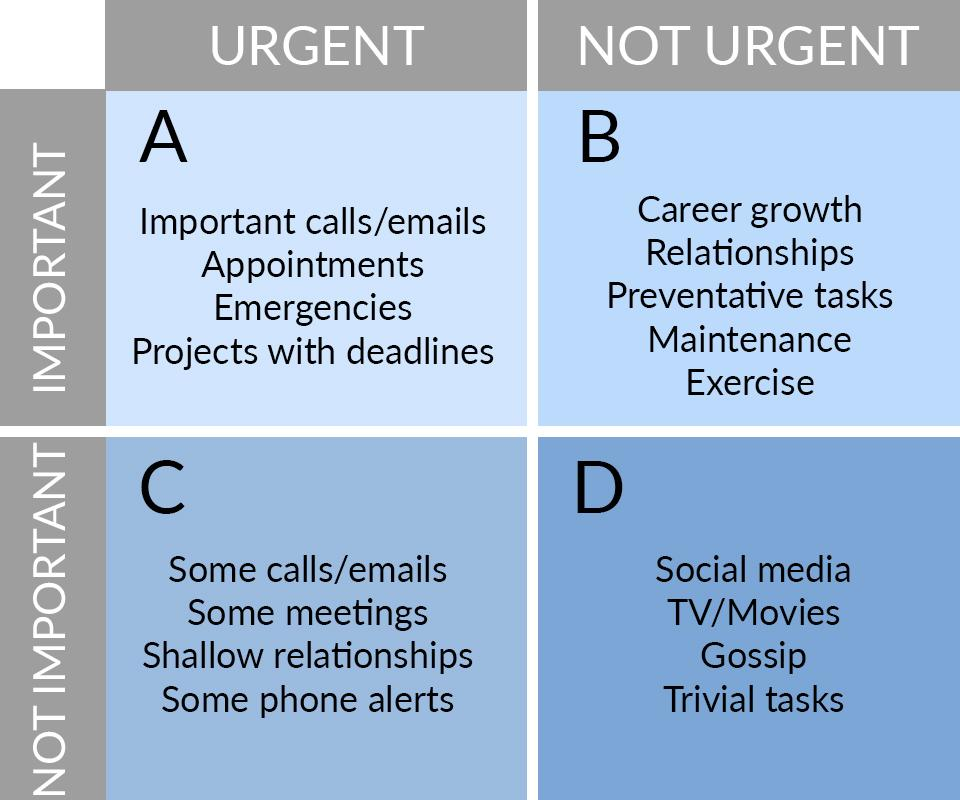

> "What is important is seldom urgent and what is urgent is seldom important."
> 
> -*Dwight Eisenhower, 34th President of the United States*


In [156]:
eisen_quad = as.data.frame(qn_df) %>%
  select(subjectID, contains('eisen')) %>%
  lapply(as.numeric) %>%
  data.frame() %>%
    rename(eisen_urg_imp = plan_eisenhow_1,
           eisen_Xurg_imp = plan_eisenhow_2,
           eisen_urg_Ximp = plan_eisenhow_3,
           eisen_Xurg_Ximp = plan_eisenhow_4
          )

# Validation Measures

Measure were selected for validation that we thought should correlate with the intention behavior gap measure.

**Note to self:** Need to deal with the cell below 

In [157]:
# # test for people choosing only one score
# test_range = socialQs
# which(apply(test_range[,-1], 1, range)[2,] - apply(test_range[,-1], 1, range)[1,] ==0)

# # perform reliability analysis
# factor_data %>% select(paste0('Item', 13:17)) %>% alpha(keys = TRUE)

### Conscientiousness HEX

[Link](https://docs.google.com/document/d/1b0WjZsNsMxHur6lm0tFo11LWIF7kCtC6WtYa6S6lGAc/edit)

- 1: strongly disagree
- 5: strongly agree

In [31]:
conscientiousness_hex <- select(q_df, studentNumber, version, starts_with("con_hex")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

conscientiousness_hex = as_tibble(conscientiousness_hex)
# select reversed score columns
cols = conscientiousness_hex %>% select(contains('r_')) %>% names()
# reverse their scores
conscientiousness_hex[, cols] = 6 - conscientiousness_hex[, cols]

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [32]:
conscientiousness_hex_s = conscientiousness_hex %>%
  mutate(con_hex_score = rowMeans(.[,c(2:dim(conscientiousness_hex)[2])], na.rm = T)) %>%
  select(con_hex_score)

### Flourishing

[Link](https://docs.google.com/document/d/14yEdkOxY-wrde67vkZFGWRpXYQnvbM3VbkS-M4O61Io/edit)

**7 Point Likert**
1. Strongly disagree 
7. Strongly agree

No reverse scoring

In [33]:
flourishing <- select(q_df, studentNumber, version, starts_with("flourishing")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [34]:
flourishing_s = flourishing %>%
  as_tibble() %>%
  mutate(flourish_score = rowMeans(.[,c(2:dim(flourishing)[2])], na.rm = T)) %>%
  select(flourish_score)

### Food Screener

[Link](https://docs.google.com/document/d/1kP5gELHH__i5chog26FsoMkZIh02cZrf8s1PFrIkesQ/edit#)

**Fruit & Vegetable Screener**: Likert 0-5
- 0 = less than 1/WEEK
- 1 = Once a WEEK
- 2 = 2-3 times a WEEK 
- 3 = 4-6 times a WEEK
- 4 = Once a DAY          
- 5 = 2+ a DAY

**Fat Screener**: Likert 0-4
- 0 = 1/MONTHor less     
- 1 = 2-3 times a MONTH     
- 2 = 1-2 times a WEEK 
- 3 = 3-4 times a WEEK
- 4 = 5+ times a WEEK

For scoring basically higher scores just mean you consume items in that category more frequently

No reverse scoring

In [35]:
food_screener <- select(q_df, studentNumber, version, starts_with("food")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

food_screener = as_tibble(food_screener)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [36]:
# subscales
fat = food_screener %>% select(contains('fat')) %>% rowMeans(na.rm = T)
fruit_veg = food_screener %>% select(contains('fruit')) %>% rowMeans(na.rm = T)

# join
food_screener_s = tibble(fat, fruit_veg)

### Harmony in Life

[Link](https://docs.google.com/document/d/1Fj-qJIvi43FleOg7lG7SXeIvGEtAYDy_MZUP8D2-fT0/edit#)

Emphasizes psychological balance and flexibility in life. 

**7 Point Likert**
- 7 - Strongly agree
- 1 - Strongly disagree 

No reverse scoring

In [37]:
harmony <- select(q_df, studentNumber, version, starts_with("harmony")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [38]:
harmony_s = harmony %>%
  as_tibble() %>%
  mutate(harmony_score = rowMeans(.[,c(2:dim(harmony)[2])], na.rm = T)) %>%
  select( harmony_score)

### Quality of Life

[Link](https://docs.google.com/document/d/1_j2ziDtn_QfTM7Ow07-BB72OgbZ4yjplGwO2Y9i6aYw/edit#)

> The QOLS is a valid instrument for measuring quality of life across patient groups and cultures and is conceptually distinct from health status or other causal indicators of quality of life.


**7 Point Likert**
- 7 - Delighted
- 6 - Pleased
- 5 - Mostly Satisfied
- 4 - Mixed
- 3 - Mostly Dissatisfied
- 2 - Unhappy
- 1 - Terrible

No reverse scoring

In [39]:
qualityLife <- select(q_df, studentNumber, version, starts_with("qol")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [40]:
qualityLife_s = qualityLife %>%
  as_tibble() %>%
  mutate(qualityLife_score = rowMeans(.[,c(2:dim(qualityLife)[2])], na.rm = T)) %>%
  select( qualityLife_score)

### SWLS (5)

[Link](https://docs.google.com/document/d/1Rp-afpwpUtZTr6t_I5gcXyKvUpUix2GYbQ0viIJAbcM/edit)

- 1: strongly disagre
- 7: strongly agree
- no reverse scoring

In [41]:
SWL5 <- select(q_df, studentNumber, version, starts_with("swl_scale")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

SWL5_s = SWL5 %>%
  as_tibble() %>%
  mutate(SWL5_score = rowMeans(.[,c(2:dim(SWL5)[2])], na.rm = T)) %>%
  select( SWL5_score)


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


### Social Desirability

[Link](https://docs.google.com/document/d/176SizGcg7u4SyskMlSAPxifTxk53i1GeEPeSbW4XE6s/edit#)

> A high score indicates a social desirability response tendency

**True/False**
- T=1, F=2)
- Reverse score the following items: 5, 7, 9, 10, 13

In [42]:
socialD <- select(q_df, studentNumber, version, starts_with("social")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [43]:
socialD = as_tibble(socialD)
# select reversed score columns
cols = socialD %>% select(ends_with('r')) %>% names()
# reverse their scores
socialD[, cols] = 3 - socialD[, cols]

In [44]:
socialD_s = socialD %>%
  mutate(socialD_score = rowMeans(.[,c(2:dim(socialD)[2])], na.rm = T)) %>%
  select(socialD_score)

### Subjective Happiness

[Link](https://docs.google.com/document/d/1QHS7y2EYv66X6khnsYcfYEAklRmmf1N9lF8lpaYkLlQ/edit)

> global subjective happiness. 

> Two items ask respondents to characterize themselves using both absolute ratings and ratings relative to peers, whereas the other two items offer brief descriptions of happy and unhappy individuals and ask respondents the extent to which each characterization describes them. 

- 1: Not at all
- 7: A great deal
- Reverse scoring: 4

In [45]:
subjectHappy <- select(q_df, studentNumber, version, starts_with("happiness")) %>% as_tibble() %>% mutate_all(as.numeric) %>% data.table()

subjectHappy = as_tibble(subjectHappy)
# select reversed score columns
cols = subjectHappy %>% select(ends_with('r')) %>% names()
# reverse their scores
subjectHappy[, cols] = 6 - subjectHappy[, cols]

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [46]:
subjectHappy_s = subjectHappy %>%
  mutate(subjectHappy_score = rowMeans(.[,c(2:dim(subjectHappy)[2])], na.rm = T)) %>%
  select(subjectHappy_score)

# Join Scales

In [47]:
q_df$conscientiousness_hex = conscientiousness_hex_s
q_df$flourishing = flourishing_s
q_df$food_screener_fat = food_screener_s$fat
q_df$food_screener_fruit_veg = food_screener_s$fruit_veg
q_df$harmony = harmony_s
q_df$qualityLife = qualityLife_s
q_df$SWL5 = SWL5_s
q_df$socialD = socialD_s
q_df$subjectHappy = subjectHappy_s

## Split to onboarding offboarding

In [48]:
onB = q_df %>%
    filter(version == 'onB') %>%
    select(-version) %>%
    as_tibble()

offB = q_df %>%
    filter(version == 'offB') %>%
        select(-version) %>%
    as_tibble()

In [49]:
colnames(onB) <- paste0('onB_', colnames(onB))
onB$studentNumber = onB$onB_studentNumber
onB = onB %>% select(-onB_studentNumber)



In [50]:
colnames(offB) <- paste0('offB_', colnames(offB))
offB$studentNumber = offB$offB_studentNumber
offB = offB %>% select(-offB_studentNumber)

In [51]:
q_onOff = merge(onB, offB, by = 'studentNumber', all=TRUE)

In [52]:
run1_subs_full = run1_subs_full %>%
    select(c(ParticipantIdentifier, `Student Number`)) %>%
rename(
        studentNumber = `Student Number`
    )

In [53]:
q_onOff = merge(x = q_onOff, y = run1_subs_full, by = "studentNumber", all.x = TRUE)

### Remove sensitive/irrelevant columns

In [58]:
q_onOff = q_onOff %>%
    select(-c(offB_consent_sonaID, onB_consent_sonaID,
              offB_social_media_1, offB_social_media_2, offB_social_media_3, offB_social_media_4, 
              onB_social_media_1, onB_social_media_2, onB_social_media_3, onB_social_media_4, 
              studentNumber,
              offB_RecipientFirstName, offB_RecipientLastName, offB_RecipientEmail,
              onB_RecipientFirstName, onB_RecipientLastName, onB_RecipientEmail,
              offB_LocationLatitude, offB_LocationLongitude,
              onB_LocationLatitude, onB_LocationLongitude,
              onB_IPAddress, offB_IPAddress,
              
             ))

In [60]:
write_csv(q_onOff, '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run1_qualtrics.csv')

In [218]:
filename = paste0('../../3_1_2_processed_data/VIB_measure_cleaned_data', Sys.Date(), '.RData')

# Save created dataframes for analysis
save(q_df, qn_df, ib_measures_df, validation_measures, demographics, ib_gap_domains,
     file = filename)


## Streamlit file

In [204]:
# create larger file
write.csv(demographics, '../../3_1_2_processed_data/streamlit_demo.csv')

In [205]:
# create larger file
df_streamlit = merge(ib_measures_df, validation_measures, by = 'subjectID') %>%
  merge(eisen_quad, by= 'subjectID')

write.csv(df_streamlit, '../../3_1_2_processed_data/streamlit.csv')

In [206]:
head(df_streamlit)

,subjectID,overall_gap_pre,overall_gap_post,global_achieve_gap,global_belief_gap,belief_achieve_gap,cat_intend_gap,domain_gap,w_domain_gap,overall_value_gap,⋯,ccs_virtue,ccs_tradition,ccs_selfC,ccs_responsibility,ccs_industriousness,needForCognition_score,eisen_urg_imp,eisen_Xurg_imp,eisen_urg_Ximp,eisen_Xurg_Ximp
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,15,19,22.50,5.75,16.75,225.000000,1.380000,1.680000,20,⋯,28,34,31,33,30,53,50,35,10,5
2,2,55,60,49.75,65.00,-15.25,0.000000,2.700000,3.900000,60,⋯,38,17,19,38,24,49,50,10,10,30
3,3,40,35,36.25,25.00,11.25,0.000000,2.769231,3.288462,35,⋯,25,32,43,38,41,58,30,20,30,20
4,4,27,52,7.25,5.50,1.75,22.916667,4.125000,3.937500,50,⋯,36,37,41,40,40,42,50,20,10,20
5,5,15,25,21.75,18.75,3.00,8.333333,2.795455,2.914773,35,⋯,40,34,41,43,43,65,10,40,20,30
6,6,30,40,22.50,0.00,22.50,4.166667,2.857143,3.196429,30,⋯,35,32,41,34,43,35,50,0,0,50


In [207]:
cor(df_streamlit$w_domain_gap, df_streamlit$domain_gap)

[1] 0.8593159